# 1. Imports & data

In [72]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv("data_for_train.csv")
data = data.drop('Unnamed: 0', axis=1)

data  

,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,...,appCat.communication_normalized,appCat.entertainment_normalized,appCat.other_normalized,appCat.social_normalized,day_of_week_sin,day_of_week_cos,month_sin,month_cos,high_activity,mood_category
0,AS14.01,2014-03-30,0.233209,4.2,3.4,7.500000,-0.500000,0.75,0.110931,414.365,...,0.372039,0.439992,0.021203,0.048044,-0.781831,0.623490,1.000000,6.123234e-17,0,high
1,AS14.01,2014-03-31,0.610632,6.0,2.0,7.400000,0.000000,0.60,0.159315,2961.405,...,0.456868,0.150693,0.023008,0.115716,0.000000,1.000000,1.000000,6.123234e-17,0,high
2,AS14.01,2014-04-01,0.886055,1.0,1.6,6.000000,0.200000,0.00,0.267636,1385.517,...,0.445810,0.075378,0.008863,0.368616,0.781831,0.623490,0.866025,-5.000000e-01,0,low
3,AS14.01,2014-04-04,0.638632,2.0,1.0,6.200000,0.200000,0.40,0.286269,1957.829,...,0.487356,0.137382,0.015719,0.185478,-0.433884,-0.900969,0.866025,-5.000000e-01,0,low
4,AS14.01,2014-04-05,0.172171,2.0,3.2,6.800000,-0.400000,0.60,0.268900,15159.190,...,0.107337,0.004348,0.004619,0.020678,-0.974928,-0.222521,0.866025,-5.000000e-01,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,AS14.33,2014-05-11,0.275172,3.2,2.8,6.000000,0.000000,0.40,0.025225,259.893,...,0.094652,0.067092,0.010046,0.779455,-0.781831,0.623490,0.500000,-8.660254e-01,0,low
917,AS14.33,2014-05-12,0.800801,1.0,2.0,6.000000,-0.750000,0.50,0.054270,1196.532,...,0.150803,0.067181,0.041487,0.571242,0.000000,1.000000,0.500000,-8.660254e-01,0,low
918,AS14.33,2014-05-13,0.970030,1.0,2.0,5.000000,0.500000,0.00,0.316265,2505.530,...,0.379729,0.107784,0.003460,0.289844,0.781831,0.623490,0.500000,-8.660254e-01,0,low
919,AS14.33,2014-05-14,0.213907,1.6,3.0,6.833333,-0.333333,0.40,0.009006,268.980,...,0.029908,0.203304,0.018769,0.698016,0.974928,-0.222521,0.500000,-8.660254e-01,0,medium


# 2. Create mood_category

In [25]:
data['mood_category'] = pd.qcut(
    data['mood'], 3, labels=["Low", "Medium", "High"]
)

# Check distribution
print(data['mood_category'].value_counts())

Low       329
Medium    300
High      292
Name: mood_category, dtype: int64


# 3. Split dataset for train in folds

In [27]:
X_all = data.drop(columns=['mood_category', 'id', 'date', 'mood'], errors='ignore')
y = data['mood_category']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 4. Train baseline RF

In [30]:
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)

baseline_scores = []
fold = 1

for train_index, test_index in tscv.split(X_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    baseline_model.fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    baseline_scores.append(acc)
    print(f"Accuracy for fold {fold}: {acc}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    fold += 1

avg_acc_all = sum(baseline_scores) / len(baseline_scores)
print("Average accuracy across all time-splits (ALL features):", avg_acc_all)

Accuracy for fold 1: 0.803921568627451
Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.57      0.63        23
         Low       0.92      0.88      0.90       110
      Medium       0.45      0.65      0.53        20

    accuracy                           0.80       153
   macro avg       0.70      0.70      0.69       153
weighted avg       0.83      0.80      0.81       153

Accuracy for fold 2: 0.738562091503268
Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.74      0.72        35
         Low       0.64      0.81      0.71        37
      Medium       0.83      0.70      0.76        81

    accuracy                           0.74       153
   macro avg       0.72      0.75      0.73       153
weighted avg       0.75      0.74      0.74       153

Accuracy for fold 3: 0.7124183006535948
Classification Report:
              precision    recall  f1-score   suppo

# 5. Feature Importance 


In [37]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_all, y)

dfscores = pd.DataFrame(selector.scores_, index=X_all.columns, columns=['Score'])
top20 = dfscores.sort_values('Score', ascending=False).head(20)
print(top10)

important_features = list(top20.index)
print("Selected important features:", important_features)

# Redefine X to the selected features for tuning/plots
X = data[important_features]

                           Score
mood_mean_3d          348.688294
mood_median_3d        313.634888
mood_min_3d           256.896232
mood_max_3d           217.411884
mood_mean_7d          211.430813
mood_median_7d        198.893028
circumplex.valence    189.928032
mood_min_7d           132.560816
mood_max_7d           102.247398
mood_lag1              86.216323
mood_std_7d            43.454897
mood_lag2              41.137375
mood_std_3d            38.326752
mood_lag3              31.495056
mood_lag7              30.070831
valence_lag1           25.123450
appCat.entertainment   18.800181
arousal_lag2           14.798326
screen                 13.925721
activity               12.676624
Selected important features: ['mood_mean_3d', 'mood_median_3d', 'mood_min_3d', 'mood_max_3d', 'mood_mean_7d', 'mood_median_7d', 'circumplex.valence', 'mood_min_7d', 'mood_max_7d', 'mood_lag1', 'mood_std_7d', 'mood_lag2', 'mood_std_3d', 'mood_lag3', 'mood_lag7', 'valence_lag1', 'appCat.entertainment', 'arou

# 6. Retrain RF using selected features

In [56]:
top_k = 17  # change to e.g. 15 or 20 to test a wider feature set

if 'important_features' not in globals() or important_features is None or len(important_features) == 0:
    assert 'selector' in globals() and 'X_all' in globals(), "Run the SelectKBest cell first."
    tmp_scores = pd.DataFrame(selector.scores_, index=X_all.columns, columns=['Score']).sort_values('Score', ascending=False)
    important_features = list(tmp_scores.index)

selected_features = important_features[:top_k]
print("Using features:", selected_features)

# Build X with selected features
X_sel = data[selected_features]
y_sel = y  

# Retrain RF with TimeSeriesSplit on selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)

selected_scores = []
fold = 1

for train_index, test_index in tscv.split(X_sel):
    X_train, X_test = X_sel.iloc[train_index], X_sel.iloc[test_index]
    y_train, y_test = y_sel.iloc[train_index], y_sel.iloc[test_index]

    rf_selected.fit(X_train, y_train)
    y_pred = rf_selected.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    selected_scores.append(acc)
    print(f"Accuracy for fold {fold} (selected features): {acc}")
    print("Classification Report (selected features):")
    print(classification_report(y_test, y_pred))
    fold += 1

avg_acc_selected = sum(selected_scores) / len(selected_scores)
print("Average accuracy across all time-splits (selected features):", avg_acc_selected)


try:
    print("Baseline (ALL features) average accuracy:", avg_acc_all)
    delta = avg_acc_selected - avg_acc_all
    print(f"Δ accuracy (selected - all): {delta:+.4f}")
except NameError:
    pass  # baseline not available in scope

Using features: ['mood_mean_3d', 'mood_median_3d', 'mood_min_3d', 'mood_max_3d', 'mood_mean_7d', 'mood_median_7d', 'circumplex.valence', 'mood_min_7d', 'mood_max_7d', 'mood_lag1', 'mood_std_7d', 'mood_lag2', 'mood_std_3d', 'mood_lag3', 'mood_lag7', 'valence_lag1', 'appCat.entertainment']
Accuracy for fold 1 (selected features): 0.8104575163398693
Classification Report (selected features):
              precision    recall  f1-score   support

        High       0.76      0.83      0.79        23
         Low       0.94      0.85      0.90       110
      Medium       0.39      0.55      0.46        20

    accuracy                           0.81       153
   macro avg       0.70      0.74      0.72       153
weighted avg       0.84      0.81      0.82       153

Accuracy for fold 2 (selected features): 0.8235294117647058
Classification Report (selected features):
              precision    recall  f1-score   support

        High       0.74      0.91      0.82        35
         Low   

# 7. Hyperparameter Tuning (RandomizedSearchCV) on Selected Features

In [59]:
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(10, 101, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42)

random_search_sel = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=100,           # keep same as before
    cv=tscv,              # TimeSeries CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_sel.fit(X_sel, y_sel)

print("Best parameters (selected features):", random_search_sel.best_params_)
best_model_sel = random_search_sel.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (selected features): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}


# 8. Evaluate tuned model with TSCV

In [64]:
# Recreate the tuned model from your best params (for clarity)
best_model_sel = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=30,
    bootstrap=False,
    random_state=42
)

def evaluate_model(model, X, y, cv):
    scores = []
    reports = []
    fold = 1
    for tr_idx, te_idx in cv.split(X):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        scores.append(acc)
        print(f"Accuracy for fold {fold} (tuned): {acc:.4f}")
        print("Classification Report (tuned):")
        print(classification_report(y_te, y_pred))
        fold += 1
    return scores

tuned_scores_sel = evaluate_model(best_model_sel, X_sel, y_sel, tscv)

avg_tuned_sel = sum(tuned_scores_sel)/len(tuned_scores_sel)
print(f"Average accuracy across all time-splits (tuned, selected features): {avg_tuned_sel:.4f}")


Accuracy for fold 1 (tuned): 0.8627
Classification Report (tuned):
              precision    recall  f1-score   support

        High       0.73      0.83      0.78        23
         Low       0.94      0.93      0.94       110
      Medium       0.58      0.55      0.56        20

    accuracy                           0.86       153
   macro avg       0.75      0.77      0.76       153
weighted avg       0.86      0.86      0.86       153

Accuracy for fold 2 (tuned): 0.8039
Classification Report (tuned):
              precision    recall  f1-score   support

        High       0.70      0.89      0.78        35
         Low       0.73      0.89      0.80        37
      Medium       0.92      0.73      0.81        81

    accuracy                           0.80       153
   macro avg       0.79      0.84      0.80       153
weighted avg       0.83      0.80      0.81       153

Accuracy for fold 3 (tuned): 0.8562
Classification Report (tuned):
              precision    recall  f1

                 Feature  Importance
1         mood_median_3d    0.150008
2            mood_min_3d    0.136483
3            mood_max_3d    0.112041
0           mood_mean_3d    0.104768
11             mood_lag2    0.098431
9              mood_lag1    0.086367
6     circumplex.valence    0.082508
12           mood_std_3d    0.054289
4           mood_mean_7d    0.038917
5         mood_median_7d    0.026269
15          valence_lag1    0.023157
10           mood_std_7d    0.020628
8            mood_max_7d    0.017108
7            mood_min_7d    0.016195
16  appCat.entertainment    0.012665
13             mood_lag3    0.011010
14             mood_lag7    0.009157


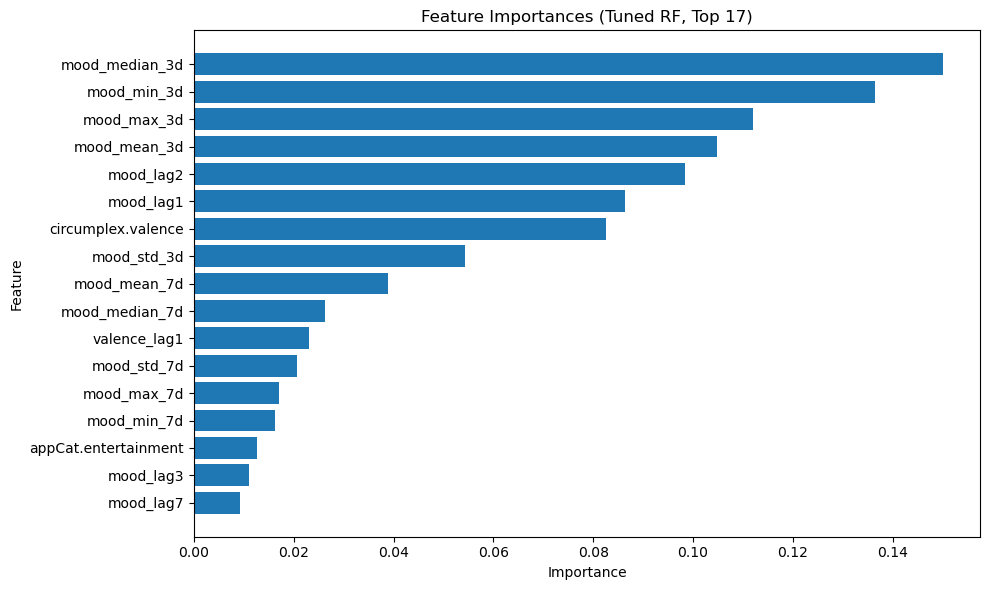

In [66]:
best_model_sel.fit(X_sel, y_sel)

importances = best_model_sel.feature_importances_
imp_df = pd.DataFrame({"Feature": X_sel.columns, "Importance": importances}).sort_values("Importance", ascending=False)
print(imp_df)

plt.figure(figsize=(10, 6))
plt.barh(imp_df["Feature"][:17][::-1], imp_df["Importance"][:17][::-1])
plt.title("Feature Importances (Tuned RF, Top 17)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


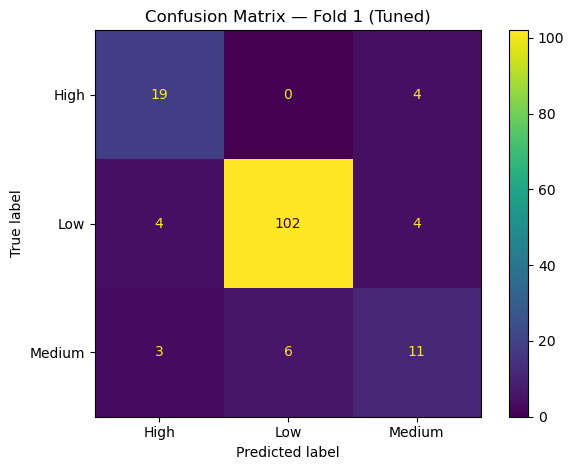

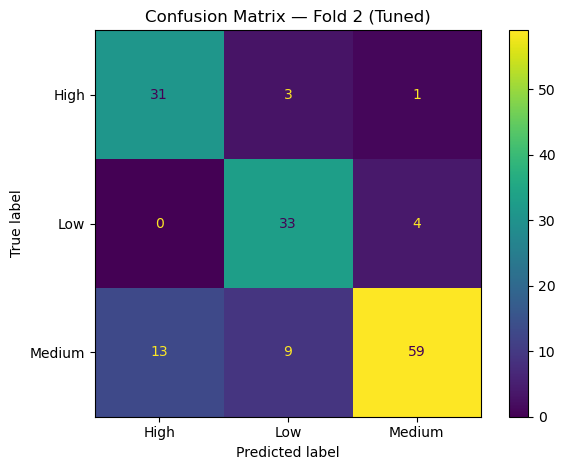

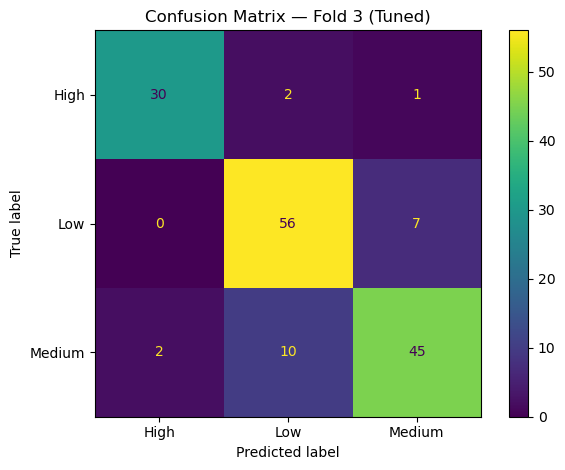

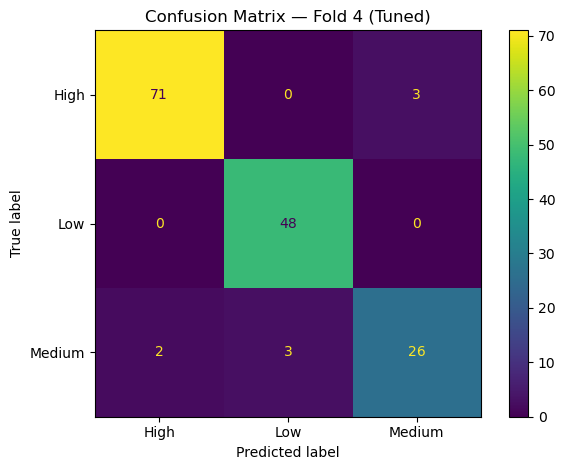

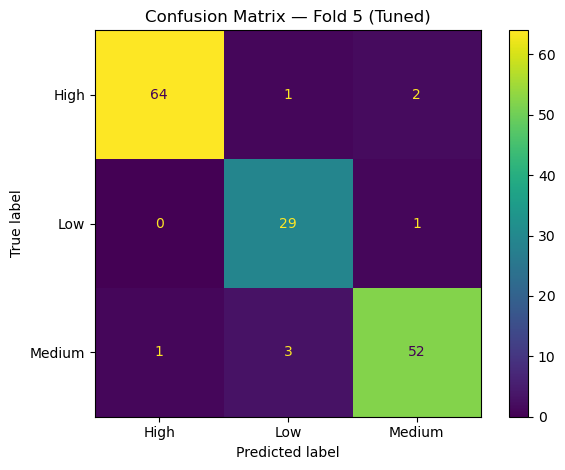

In [70]:
fold = 1
for tr_idx, te_idx in tscv.split(X_sel):
    X_tr, X_te = X_sel.iloc[tr_idx], X_sel.iloc[te_idx]
    y_tr, y_te = y_sel.iloc[tr_idx], y_sel.iloc[te_idx]
    best_model_sel.fit(X_tr, y_tr)
    y_pred = best_model_sel.predict(X_te)

    cm = confusion_matrix(y_te, y_pred, labels=best_model_sel.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_sel.classes_)
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix — Fold {fold} (Tuned)")
    plt.tight_layout()
    plt.show()
    fold += 1

In [74]:
import joblib
joblib.dump(best_model_sel, "rf_tuned_top17.joblib")
print("Saved rf_tuned_top17.joblib")

Saved rf_tuned_top17.joblib
